In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import time

#Units and constants
G     = 6.67E-11        #Gravitational constant in N.m²/kg²
au    = 149597870700    #Mean distance Earth-Sun in m
msol  = 2e30            #Mass of the sun in kg
earth = 3e-6            #Mass of the earth as a fraction of Msol
hour  = 3600            #Duration of an hour in seconds
day   = hour*24         #Duration of a day in seconds
year  = day*365.25636   #Duration of an year in seconds

In [2]:
def norm_vec(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

def COM_pos(body_list):
    vec = np.array([0., 0., 0.], dtype = np.float64)
    mtot = 0
    for body in body_list:   
        vec += body.mass * body.position
        mtot += body.mass   
    return vec/mtot

def COM_vel(body_list):
    vec = np.array([0., 0., 0.], dtype = np.float64)
    M = 0  
    for body in body_list:
        vec += body.mass * body.velocity
        M += body.mass     
    return vec/M

def total_mass(body_list):
    M = 0
    for c in body_list:
        M += c.mass
    return M

def velocity_reduced_mass(body_list, e):
    r = norm_vec(body_list[0].position-body_list[1].position)
    return np.sqrt((1-e)*(G*total_mass(body_list))/r)
        
def compute_positions(body_list, excentricity, axis):
    aph = axis*(1+excentricity)
    pos1 = aph* body_list[1].mass/(body_list[0].mass + body_list[1].mass)
    pos2 = aph* body_list[0].mass/(body_list[0].mass + body_list[1].mass)
    pos_c1 = np.array([pos1, 0., 0.], dtype = np.float64)
    pos_c2 = np.array([-pos2, 0., 0.], dtype = np.float64)
    return pos_c1, pos_c2
    
def compute_velocities(body_list, e):
    v_mu = velocity_reduced_mass(body_list, e)
    v1 = v_mu * body_list[1].mass/(body_list[0].mass + body_list[1].mass)
    v2 = v_mu * body_list[0].mass/(body_list[0].mass + body_list[1].mass)
    v_c1 = np.array([0., v1, 0.], dtype = np.float64)
    v_c2 = np.array([0., -v2, 0.], dtype = np.float64)
    return v_c1, v_c2
        
def initialize_body(body_list, e, axis):
    p_c1, p_c2 = compute_positions(body_list, e, axis)
    body_list[0].position = p_c1
    body_list[1].position = p_c2
    body_list[0].initial_position = p_c1
    body_list[1].initial_position = p_c2
    
    v_c1, v_c2 = compute_velocities(body_list, e)
    body_list[0].velocity = v_c1
    body_list[1].velocity = v_c2
    body_list[0].initial_velocity = v_c1
    body_list[1].initial_velocity = v_c2
    
    for body in body_list:
        body.setup_coord_in_COM(body_list)
        # body.display_infos()
    
def reset_body(body_list):
    for body in body_list:
        body.reset()
        
def update_velpos_bs1_to_bs2_com(bs1,bs2,phi) : 
    bs1.body_list[0].position = bs1.body_list[0].position + bs2.body_list[0].position
    bs1.body_list[1].position = bs1.body_list[1].position + bs2.body_list[0].position

    triple = [bs1.body_list[0], bs1.body_list[1], bs2.body_list[1]]
    
    dpy=(1-np.cos(phi))*bs2.body_list[1].mass*norm_vec(bs2.body_list[1].velocity)/total_mass(triple)
    dpz=-(np.sin(phi))*bs2.body_list[1].mass*norm_vec(bs2.body_list[1].velocity)/total_mass(triple)

    bs1.body_list[0].velocity = bs1.body_list[0].velocity + bs2.body_list[0].velocity - [0,dpy,dpz]
    bs1.body_list[1].velocity = bs1.body_list[1].velocity + bs2.body_list[0].velocity - [0,dpy,dpz]
    bs2.body_list[1].velocity = bs2.body_list[1].velocity - [0,dpy,dpz]
    
    triple = [bs1.body_list[0], bs1.body_list[1], bs2.body_list[1]]

    return triple

In [3]:
#Creating a class that contains all the properties of a body (mass, name, position in different coordinates systems, velocity,...)
class body():
    def __init__(self, name, mass):
        self.name = name       
        self.mass = mass
        self.initial_position = np.array([0., 0., 0.], dtype = np.float64)
        self.initial_velocity = np.array([0., 0., 0.], dtype = np.float64)   
        self.position = np.array([0., 0., 0.], dtype = np.float64)
        self.velocity = np.array([0., 0., 0.], dtype = np.float64)
        self.a = np.array([0.,0.,0.], dtype = np.float64)         #Acceleration
        self.a_pt = np.array([0.,0.,0.], dtype = np.float64)      #Jerk
        self.a_prime = np.array([0.,0.,0.], dtype = np.float64)
        self.a_pt_prime = np.array([0.,0.,0.], dtype = np.float64)
        self.a_2 = np.array([0.,0.,0.], dtype = np.float64)
        self.a_3 = np.array([0.,0.,0.], dtype = np.float64)        

    def vec_position_in_COM(self, body_list):        
        return self.position - COM_pos(body_list)
    
    def vec_velocity_in_COM(self, body_list):
        return self.velocity - COM_vel(body_list)
    
    def setup_coord_in_COM(self, body_list):
        self.position = self.vec_position_in_COM(body_list)
        self.velocity = self.vec_velocity_in_COM(body_list)

    def rotate_velocity(self, phi):
        self.velocity[2] = self.velocity[1]*np.sin(phi)
        self.velocity[1] = self.velocity[1]*np.cos(phi)

    def reset(self):
        self.position = self.initial_position
        
    def display_infos(self):
        print(f'Objet : {self.name}, x : {self.position[0]}, y : {self.position[1]}, vx : {self.velocity[0]}, vy : {self.velocity[1]}, vz : {self.velocity[2]}')
        
    def grad_potential(self, body_list, indice):        
        res = np.array([0., 0., 0.])
        rCOM = self.position        
        for (i, body) in enumerate(body_list):            
            if i != indice:
                rCOMi = body.position                
                res += (rCOM - rCOMi) * body.mass/(pow(norm_vec(rCOM - rCOMi), 3))
        return G*res
    
    def a_dot(self, body_list, indice):        
        res = np.array([0., 0., 0.])
        rCOM = self.position
        vCOM = self.velocity
        for (i, body) in enumerate(body_list):            
            if i != indice:
                rCOMi = body.position
                vCOMi = body.velocity
                res += (body.mass/(pow(norm_vec(rCOM - rCOMi), 3))) * (((vCOM-vCOMi) - 3*np.dot((vCOM - vCOMi),(rCOM - rCOMi))*(rCOM - rCOMi))/(pow(norm_vec(rCOM - rCOMi), 2)))
        return -G*res

In [4]:
class binary_system():
    def __init__(self, c1, c2, rotation_angle = 0):
        self.body_list = [c1, c2]
        self.COM_postion = COM_pos([c1, c2])
        self.mass = total_mass([c1, c2])
        self.excentricity = 0
        self.perihelion = None
        self.aphelion = None
        self.axis = None
        self.phi = rotation_angle

    def initialize_system(self, e, axis,info=None):
        initialize_body(self.body_list, e, axis)
        self.excentricity = e
        if(e < 1):
            self.axis = axis
            self.perihelion = self.axis*(1-self.excentricity)
            self.aphelion = self.axis*(1+self.excentricity)
        self.body_list[1].rotate_velocity(self.phi)
        if info !=None : 
            self.display_infos()
        
    def reset_system(self):
        print(f'\nFinal total momentum : {self.total_momentum()}')
        print(f'Final total angular momentum : {self.total_angular_momentum()}')
        reset_body(self.body_list)

    def display_infos(self):
        print(f'Axis (in A.U.) : {self.axis/au}, Excentricity : {self.excentricity}, Initial Total momentum : {self.total_momentum()}, Initial Tot Ang Mom : {self.total_angular_momentum()}')
        # for body in self.body_list:
        #     body.display_infos()
        
    def total_momentum(self):
        return self.body_list[0].velocity*self.body_list[0].mass + self.body_list[1].velocity*self.body_list[1].mass
    
    def total_angular_momentum(self):
        L = np.array([0.,0.,0.], dtype = np.float64)
        for body in self.body_list:
            L += np.cross(body.position,body.velocity*body.mass)
        return L
        
    def compute_motion(self, integrator, step, duration):
        I = integrator(self.body_list, step, duration)
        return I

    def system_to_body(self):
        body_eq = body("system", self.mass)
        return body_eq

In [5]:
#Verlet/Leapfrog Integrator : 
def leapfrog_integrator(body_list, step, duration):

    t = 0
    time_list = [0]
    positions_t0 = []
    velocities_t0 = []

    for body in body_list: 
        positions_t0.append(body.position)
        velocities_t0.append(body.velocity)

    positions_list = [positions_t0]
    velocities_list = [velocities_t0]
        
    while t < duration:        
        t += step
        if ((t/(3600*24*365*(0.1*duration/year))).is_integer()==True):
            print(int(t/(365*day)),'/', duration/year, ' years' )
        time_list.append(t)
        positions_t = []
        velocities_t = []
        p = [0., 0., 0.]
        
        #Calcul de x' pour chaque body
        for body in body_list:
            body.position = body.position + body.velocity * (step/2)
        #Calcul de v'' et x'' pour chaque body
       
        for (i, body) in enumerate(body_list):
            body.velocity = body.velocity - step*body.grad_potential(body_list, i)
            body.position = body.position + body.velocity * (step/2)
            positions_t.append(body.position)
            velocities_t.append(body.velocity)
            p += body.velocity*body.mass

        positions_list.append(positions_t)
        velocities_list.append(velocities_t)

    return positions_list, velocities_list, time_list

In [6]:
# Hermite Scheme : 
def hermite_integrator(body_list, step, duration):
    
    t = 0
    time_list = [0]
    positions_t0 = []
    velocities_t0 = []
    
    for body in body_list: 
        positions_t0.append(body.position)
        velocities_t0.append(body.velocity)
        
    positions_list = [positions_t0]
    velocities_list = [velocities_t0]

    while t < duration:       
        t += step
        if ((t/(3600*24*365*(0.1*duration/year))).is_integer()==True):
            print(int(t/(365*day)),'/', duration/year, ' years' )
        time_list.append(t)
        positions_t = []
        velocities_t = []
        p = [0., 0., 0.]
        
        #Compute the acceleration and jerk of each body
        for (i, body) in enumerate(body_list):
            body.a = -body.grad_potential(body_list, i)
            body.a_pt = body.a_dot(body_list, i)  
        #Compute xp & vp for each body
        for (i, body) in enumerate(body_list):
            body.position = body.position + body.velocity*(step) + 0.5*(step**2)*body.a + (1/6)*(step**3)*body.a_pt
            body.velocity = body.velocity + step*body.a + 0.5*(step**2)*body.a_pt
        #Compute x' & v' for each body
        for (i, body) in enumerate(body_list):
            body.a_prime = -body.grad_potential(body_list,i)
            body.a_pt_prime = body.a_dot(body_list,i) 
            body.a_2 = -(6*(body.a-body.a_prime) + step*(4*body.a_pt + 2*body.a_pt_prime))/step**2
            body.a_3 = (12*(body.a-body.a_prime) + 6*step*(body.a_pt + body.a_pt_prime))/step**3   
        #Final, corrected coordinates are now : 
        for (i, body) in enumerate(body_list):
            body.position = body.position + ((step**4)/24)*body.a_2 + ((step**5)/120)*body.a_3
            body.velocity = body.velocity + (step**3/6)*body.a_2 + (step**4/24)*body.a_3
        #Add the position/velocity and momentum at time t+dt to their respective list
            positions_t.append(body.position)
            velocities_t.append(body.velocity)
            p += body.velocity*body.mass
            
        positions_list.append(positions_t)
        velocities_list.append(velocities_t)

    return positions_list, velocities_list, time_list

In [7]:
# Total Energy, Mechanical Energy and Angular Momentum

def energy_from_trajectory(b_s, P, V, T, plot=None):
    nb_time = len(T)
    #Total Energy
    H = np.zeros(nb_time)
    for (i,bodyi) in enumerate(b_s.body_list) :
        H += 0.5 * bodyi.mass * (np.linalg.norm(V[:,i,:],axis=1))**2
        for j in range(i+1, len(b_s.body_list)):
            bodyj = b_s.body_list[j]   
            H += -G*(bodyi.mass * bodyj.mass)/np.linalg.norm((P[:,i,:]-P[:,j,:]),axis=1)
    #Angular Momentum
    L = np.zeros((nb_time, 3))
    for (i,body) in enumerate(b_s.body_list) :
        L += body.mass * np.cross(P[:,i,:],V[:,i,:])
    #Mecanical Energy
    E = -G/(2*b_s.axis) * np.ones(nb_time)
    for (i,bodyj) in enumerate(b_s.body_list) : 
        E *= bodyj.mass
        
    Ecart=np.absolute((H-E)/E)
    max_ecart = np.max(Ecart)
    distance_list_c1_c2 = np.array([norm_vec(P[k,0] - P[k,1]) for k in range(len(T))])

    #Graphs
    if plot!=None : 
        plt.figure()
        plt.plot(T, 100 - 100*L[:,2]/L[0,2])
        plt.title('Angular Momentum deviation from Initial value (in %)')
        plt.xlabel('Time in years')
        plt.figure()
        plt.plot(T,Ecart)
        plt.title('Relative error on energy')
        plt.xlabel('Time in years')
        plt.figure()
        plt.plot(T, distance_list_c1_c2/au) #(t, distance de corps 0 à 1)
        plt.title("Distance corps0-corps1 (in A.U.)")
        plt.xlabel('Time in years')
        
    return max_ecart

In [9]:
def find_integration_step_method(fonction, C, precision, step0, duration):
    erreur = 1
    step = step0 
    
    while erreur > precision:
        B_S = binary_system(C[0], C[1])
        B_S.initialize_system(e_bin, a_bin)
        start = time.time()
        P, V, T = fonction(B_S.body_list, step, duration)
        end = time.time()
        print('Time : ', (end-start), ' seconds to execute')
        P = np.array(P)
        V = np.array(V)
        T = np.array(T)/year
        erreur = energy_from_trajectory(B_S, P, V, T)
        print('\u03B4E/E =', "{:.2E}".format(erreur) , 'for \u0394t =', "{:.3f}".format(step/day), 'days')
        step = step/2        
    return 2*step

In [17]:
binary1 = body("B1", msol)
binary2 = body("B2", msol)
binary3 = body("B3", 0.1*msol)

#Parameters
e_bin=0.                 #Excentricity of the binary
e_out=0.25                 #Excentricity of the outer body    
a_bin = 1*au             #Semi-major axis of the binary
a_out = 5*au             #Semi-major axis of the outer body
phi=80*np.pi/180          #Initial inclination of the third body plane
simu_time=2500*year       #Total time of the simulation
step = day/2

systeme_binaire = binary_system(binary1, binary2)
systeme_binaire.initialize_system(e_bin, a_bin)

body_eq = systeme_binaire.system_to_body()
systeme_binaire2 = binary_system(body_eq, binary3, phi)
systeme_binaire2.initialize_system(e_out, a_out)

triple_system = update_velpos_bs1_to_bs2_com(systeme_binaire,systeme_binaire2,phi)
positions_list3, velocities_list3, time_list3 = hermite_integrator(triple_system, step, simu_time)

positions_list3 = np.array(positions_list3, dtype=np.float64)
velocities_list3 = np.array(velocities_list3, dtype=np.float64)
time_list3 = np.array(time_list3, dtype=np.float64)

systeme_binaire.reset_system()
systeme_binaire2.reset_system()

e = np.zeros(len(positions_list3))
a = np.zeros(len(positions_list3))
r = np.zeros(len(positions_list3))

for i in range(len(positions_list3)) : 
    r = norm_vec(positions_list3[i,0,:]-positions_list3[i,1,:])
    dv = (velocities_list3[i,0,:]-velocities_list3[i,1,:])
    dr = (positions_list3[i,0,:]-positions_list3[i,1,:])
    h = np.cross(dr,dv)
    mu = (G*systeme_binaire.mass)
    e[i] = norm_vec((np.cross(dv,h)/mu) - (dr/norm_vec(dr)))
    a[i] = norm_vec(h)**2/(mu*(1-e[i]**2))

#np.savez('2500_phi50.npz', positions = positions_list3, velocities = velocities_list3, time = time_list3, a = a, e = e)

250 / 2499.9999999999995  years
500 / 2499.9999999999995  years
750 / 2499.9999999999995  years
1000 / 2499.9999999999995  years
1250 / 2499.9999999999995  years
1500 / 2499.9999999999995  years
1750 / 2499.9999999999995  years
2000 / 2499.9999999999995  years
2250 / 2499.9999999999995  years
2500 / 2499.9999999999995  years

Final total momentum : [-1.53537897e+33  1.95925143e+33 -1.32703181e+33]
Final total angular momentum : [-1.46322593e+44 -3.93773660e+45  4.89210404e+45]

Final total momentum : [1.53537897e+33 8.96077702e+32 1.32703181e+33]
Final total angular momentum : [1.44354898e+44 1.44428191e+45 2.09247074e+45]


C:\Users\Cedric\AppData\Local\Temp\ipykernel_22644\1158775745.py:5: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.plot(positions_list3[:,0,0]/au, positions_list3[:,0,1]/au, positions_list3[:,0,2]/au, color='green')
C:\Users\Cedric\AppData\Local\Temp\ipykernel_22644\1158775745.py:6: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.plot(positions_list3[:,1,0]/au, positions_list3[:,1,1]/au, positions_list3[:,1,2]/au, color='red')
C:\Users\Cedric\AppData\Local\Temp\ipykernel_22644\1158775745.py:7: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.plot(positions_list3[:,2,0

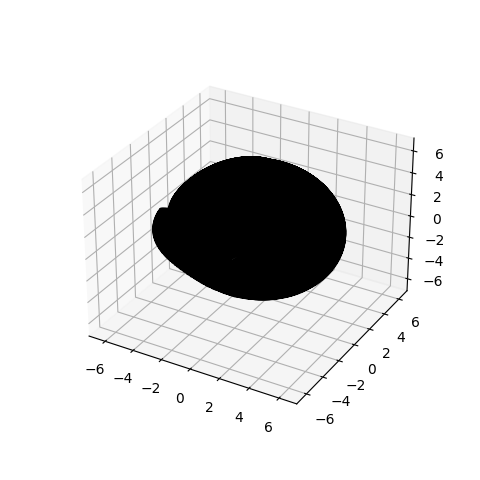

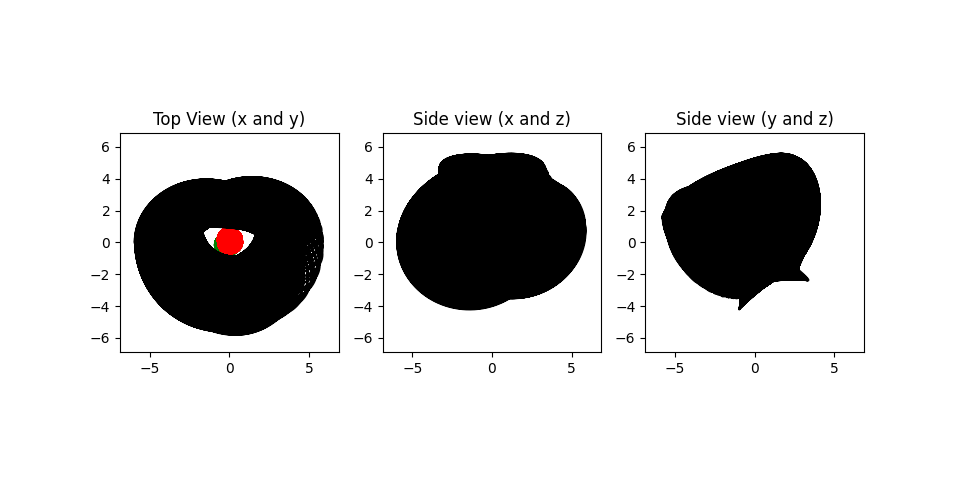

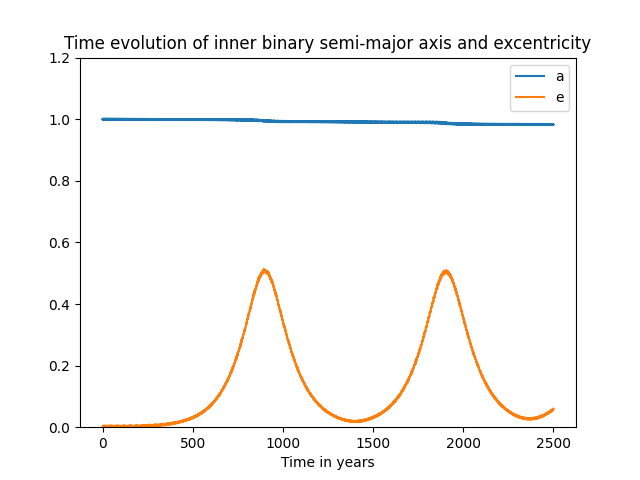

In [18]:
### Plotting The results ####

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(positions_list3[:,0,0]/au, positions_list3[:,0,1]/au, positions_list3[:,0,2]/au, color='green')
ax.plot(positions_list3[:,1,0]/au, positions_list3[:,1,1]/au, positions_list3[:,1,2]/au, color='red')
ax.plot(positions_list3[:,2,0]/au, positions_list3[:,2,1]/au, positions_list3[:,2,2]/au, color='black')
ax.set_xlim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_ylim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_zlim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
#plt.savefig('2500_phi0_3D.png')
plt.show()


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 3, 1, adjustable='box', aspect=1)
ax.plot(positions_list3[:,0,0]/au, positions_list3[:,0,1]/au, color='green')
ax.plot(positions_list3[:,1,0]/au, positions_list3[:,1,1]/au, color='red')
ax.plot(positions_list3[:,2,0]/au, positions_list3[:,2,1]/au, color='black')
ax.set_xlim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_ylim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_title('Top View (x and y)')
ax = fig.add_subplot(1, 3, 2, adjustable='box', aspect=1)
ax.plot(positions_list3[:,0,0]/au, positions_list3[:,0,2]/au, color='green')
ax.plot(positions_list3[:,1,0]/au, positions_list3[:,1,2]/au, color='red')
ax.plot(positions_list3[:,2,0]/au, positions_list3[:,2,2]/au, color='black')
ax.set_xlim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_ylim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_title('Side view (x and z)')
ax = fig.add_subplot(1, 3, 3, adjustable='box', aspect=1)
ax.plot(positions_list3[:,0,1]/au, positions_list3[:,0,2]/au, color='green')
ax.plot(positions_list3[:,1,1]/au, positions_list3[:,1,2]/au, color='red')
ax.plot(positions_list3[:,2,1]/au, positions_list3[:,2,2]/au, color='black')
ax.set_xlim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_ylim(-1.1*(1+e_out)*a_out/au, 1.1*(1+e_out)*a_out/au)
ax.set_title('Side view (y and z)')
#plt.savefig('2500_phi0_2D.png')
plt.show()


plt.figure()
plt.plot(time_list3/year, a/au, label='a')
plt.plot(time_list3/year, e, label='e')
plt.ylim(0.,1.2)
plt.xlabel('Time in years')
plt.title('Time evolution of inner binary semi-major axis and excentricity')
plt.legend()
#plt.savefig('2500_phi0_ae.png')
plt.show()

In [19]:
P_out = 7.2*year
P = (9/12)*year
q_out = triple_system[2].mass/(2*triple_system[0].mass)
g = 1.
T_KL = ((P_out**2)/P)*((1+q_out)/(q_out))*(1-e_out**2)**(3/2)*g
print('T_KL =',T_KL/year, 'years')

T_KL = 1317.5889343797633 years


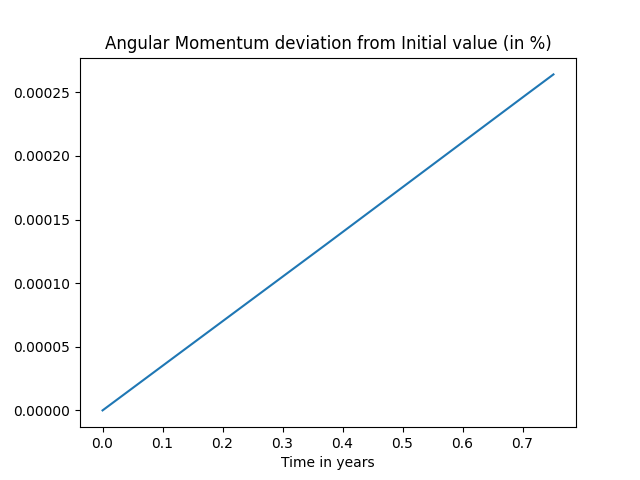

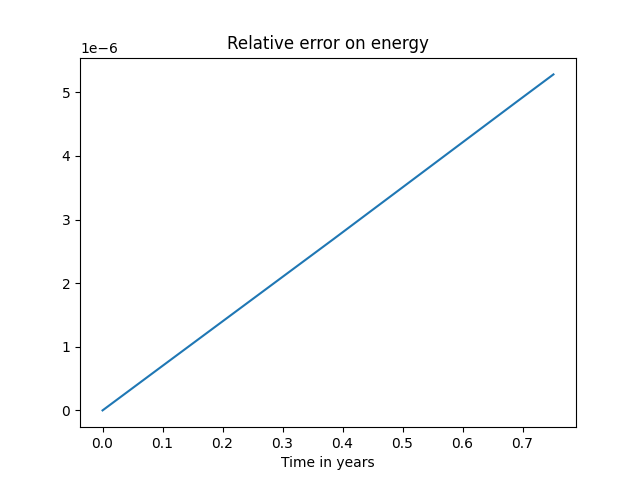

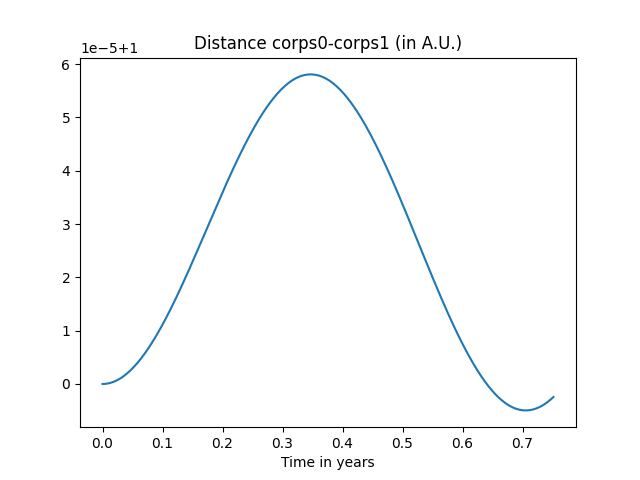

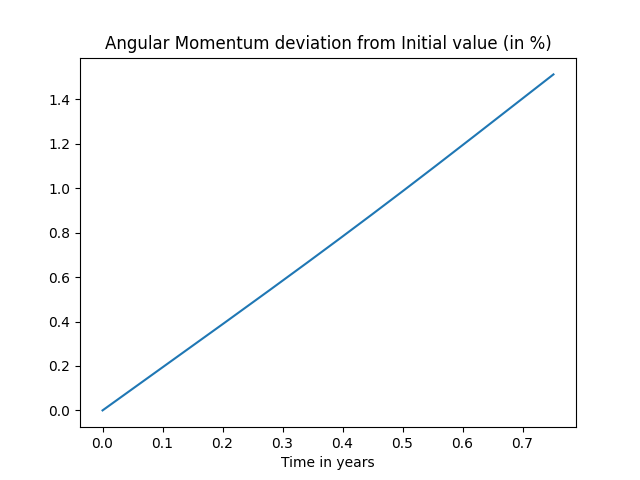

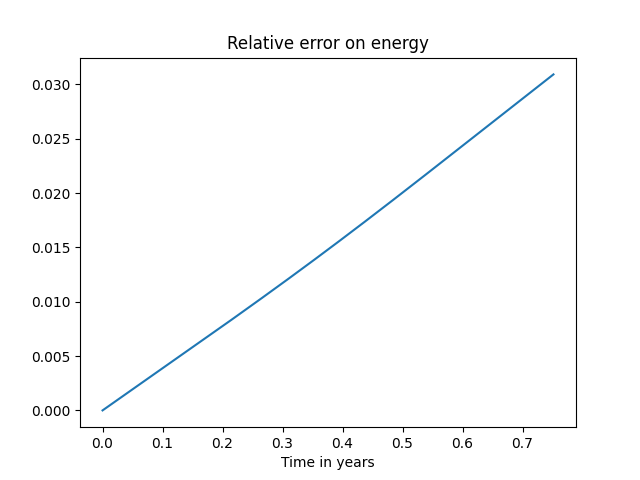

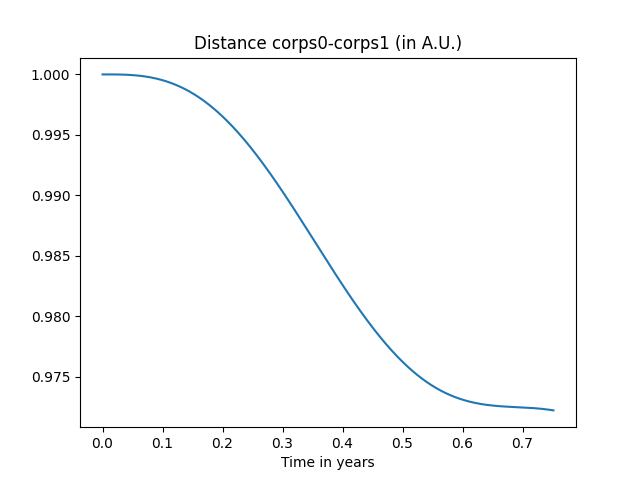

In [15]:
#Create the binary system giving them an initial position in the R0 frame : 
binary1 = body("B1", msol)
binary2 = body("B2", msol)

body_list = [binary1, binary2]

#Parameters
e_bin=0. #Excentricity of the binary
a_bin = 1*au
phi_bin=0*np.pi/180          #Initial inclination of the third body plane
simu_time=(9/12)*year   #Total time of the simulation


systeme_binaire = binary_system(binary1, binary2, rotation_angle = phi_bin)
systeme_binaire.initialize_system(e_bin, a_bin)

#to_test = 'opt_step'
to_test = 'energy_from_traj'

if to_test=='energy_from_traj' : 
    P, V, T = hermite_integrator(systeme_binaire.body_list, 0.713*day,(9/12)*year)
    P = np.array(P)
    V = np.array(V)
    T = np.array(T)/year
    erreur = energy_from_trajectory(systeme_binaire, P, V, T,1)
    
    P1, V1, T1 = leapfrog_integrator(systeme_binaire.body_list, 0.713*day,(9/12)*year)
    P1 = np.array(P1)
    V1 = np.array(V1)
    T1 = np.array(T1)/year
    erreur1 = energy_from_trajectory(systeme_binaire, P1, V1, T1,1)

if to_test=='opt_step':
    step_opt_herm = find_integration_step_method(hermite_integrator, body_list, 10**(-5), year, simu_time)
    print('')
    step_opt_leap = find_integration_step_method(leapfrog_integrator, body_list, 10**(-5), year, simu_time)
    systeme_binaire.reset_system()


In [ ]:
# time_H=[365.256,182.628,91.314,45.657,28.29,14.14,5.707,2.854,1.427,0.713]
# error_H=[21.7,6.53,1.67,5.54,0.463,0.0243,0.00278,0.000338,0.0000425,0.00000529]
        
# time_V=[365.256,182.628,91.314,45.657,28.29,14.14,5.707,2.854,1.427,0.713,0.357,0.178,0.089,0.045,0.022,0.011146739501953124,0.006,0.003,0.0015,0.0007,0.00035,0.00017]
# error_V=[1.18,0.53,3.61,5.87,31.8,125,0.466,0.152,0.0662,0.0309,0.015,0.00738,0.00666,0.00182,0.00091,0.000455,0.000227,0.000114,0.0000568,0.0000284,0.0000142,0.00000710]

# proc_H=[0.0,0.0,0.0,0.0,0.0009999275207519531,0.003513336181640625,0.005513191223144531,0.010091781616210938,0.020220279693603516,0.03678083419799805]
# proc_V=[0.0,0.0,0.0,0.0,0.001005411148071289,0.0,0.0009989738464355469,0.002000093460083008,0.004001140594482422,0.006031990051269531]

# plt.figure()
# plt.plot(time_H,error_H, label='Hermite')
# plt.plot(time_V,error_V,label='Verlet')
# plt.axhline(y=1e-5, color='r', linestyle='--')

# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('Time step in days')
# plt.ylabel('Relative Error')
# plt.legend()
# plt.gca().invert_xaxis()

# plt.figure()
# plt.plot(time_H,proc_H, label='Hermite')
# plt.plot(time_H,proc_V,label='Verlet')
# plt.xscale('log')
# plt.xlabel('Time step in days')
# plt.ylabel('Time to execute in seconds')
# plt.legend()
# plt.gca().invert_xaxis()

1 / 5.0  years
2 / 5.0  years
3 / 5.0  years
4 / 5.0  years
5 / 5.0  years

Final total momentum : [ 1.40737488e+14 -5.43158744e+14  0.00000000e+00]
Final total angular momentum : [0.00000000e+00 0.00000000e+00 2.72508588e+40]


C:\Users\Cedric\AppData\Local\Temp\ipykernel_22644\1238494972.py:26: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.plot(P[:,0,0]/au, P[:,0,1]/au, P[:,0,2]/au, color='green')
C:\Users\Cedric\AppData\Local\Temp\ipykernel_22644\1238494972.py:27: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.plot(P[:,1,0]/au, P[:,1,1]/au, P[:,1,2]/au, color='blue')


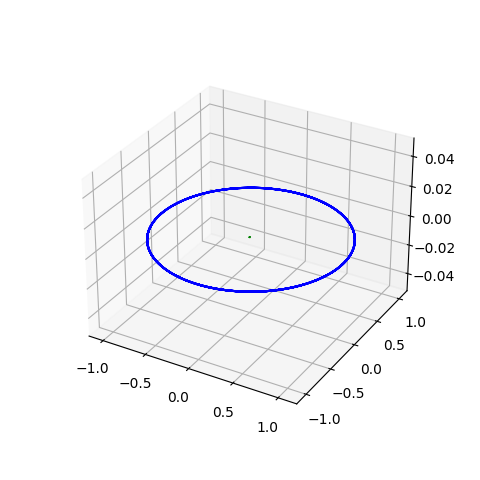

-29861.702010214853


In [11]:
#EARTH-SUN SYSTEM
binary1 = body("B1", msol)
binary2 = body("B2", earth*msol)

body_list = [binary1, binary2]

#Parameters
e_bin=0.0167 #Excentricity of the binary
a_bin = 1*au
phi_bin=0*np.pi/180          #Initial inclination of the third body plane
simu_time=5*(12/12)*year   #Total time of the simulation


systeme_binaire = binary_system(binary1, binary2, rotation_angle = phi_bin)
systeme_binaire.initialize_system(e_bin, a_bin)

positions_list, velocities_list, time_list = systeme_binaire.compute_motion(hermite_integrator, day, simu_time)
systeme_binaire.reset_system()

P = np.array(positions_list, dtype = np.float64)
V = np.array(velocities_list, dtype = np.float64)
T = np.array(time_list, dtype = np.float64)/year

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(P[:,0,0]/au, P[:,0,1]/au, P[:,0,2]/au, color='green')
ax.plot(P[:,1,0]/au, P[:,1,1]/au, P[:,1,2]/au, color='blue')
#ax.set_title("Trajectory in space")
plt.show()

print(V[0,1,1])